## Description:
Extracts a csv file of the specified temperature isocontour(in progress variable form) of the imported nek output.

In [2]:
from __future__ import annotations
from pathlib import Path
import os
_cwd = Path.cwd()
_project_root = _cwd.parent
os.chdir("..")
import yaml

from flamekit.datasets import SEMDataset
from flamekit.io_fronts import Case
from mpi4py import MPI
import matplotlib.pyplot as plt

In [3]:
# -----------------------------
# Find project root robustly
# -----------------------------
def find_project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for cand in [p, *p.parents]:
        if (cand / "flamekit").is_dir():
            return cand
    raise RuntimeError("Could not find project root (folder containing 'flamekit').")

PROJECT_ROOT = find_project_root()

CONFIG_PATH = PROJECT_ROOT / "notebooks" / "configs" / "Extract_isocontours.yaml"
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    CFG = yaml.safe_load(f)

def _resolve_path(value):
    p = Path(value)
    return p if p.is_absolute() else (PROJECT_ROOT / p)

DATA_BASE_DIR = _resolve_path(CFG["DATA_BASE_DIR"])
ISOCONTOUR_BASE_DIR = _resolve_path(CFG["ISOCONTOUR_BASE_DIR"])

TIME_STEP = int(CFG["TIME_STEP"])
MULTI_TIME_STEP = bool(CFG["MULTI_TIME_STEP"])
TIME_STEP_START = int(CFG["TIME_STEP_START"])
TIME_STEP_END = int(CFG["TIME_STEP_END"])
PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
T_REF = float(CFG["T_REF"])
P_REF = float(CFG["P_REF"])

POST = bool(CFG["POST"])
FILE_NAME = str(CFG["FILE_NAME"])

COMP_VEL_JACOBIAN = bool(CFG["COMP_VEL_JACOBIAN"])
COMP_VEL_HESSIAN = bool(CFG["COMP_VEL_HESSIAN"])
COMP_REACTION_RATES = bool(CFG["COMP_REACTION_RATES"])
COMP_T_GRAD = bool(CFG["COMP_T_GRAD"])
COMP_CURV_GRAD = bool(CFG["COMP_CURV_GRAD"])
COMP_LOCAL_VEL_JACOBIAN = bool(CFG["COMP_LOCAL_VEL_JACOBIAN"])

CANTERA_YAML = _resolve_path(CFG["CANTERA_YAML"])
CANTERA_INPUTS = [str(CANTERA_YAML), None, T_REF, P_REF]

# Progress variable isolevels (0-1)
PROGRESS_LEVELS = list(CFG["PROGRESS_LEVELS"])

comm = MPI.COMM_WORLD
rank = comm.rank


2026-01-06 14:56:13,776 - Mesh - INFO - Initializing empty Mesh object.
2026-01-06 14:56:13,777 - Field - INFO - Initializing empty Field object
2026-01-06 14:56:13,777 - pynekread - INFO - Reading file: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/phi0.40/h400x200_ref/po_postPremix0.f00001
2026-01-06 14:56:13,855 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2026-01-06 14:56:13,856 - Mesh - INFO - Initializing common attributes.
2026-01-06 14:56:13,856 - Mesh - INFO - Getting vertices
2026-01-06 14:56:13,871 - Mesh - INFO - Getting edge centers
2026-01-06 14:56:14,060 - Mesh - INFO - Facet centers not available for 2D
2026-01-06 14:56:14,061 - Mesh - INFO - Mesh object initialized.
2026-01-06 14:56:14,061 - Mesh - INFO - Mesh data is of type: float64
2026-01-06 14:56:14,061 - Mesh - INFO - Elapsed time: 0.20605887899999997s
2026-01-06 14:56:14,061 - pynekread - INFO - Reading field data
2026-01-06 14:56:14,061 - pynekread - INFO - Overwriting fl

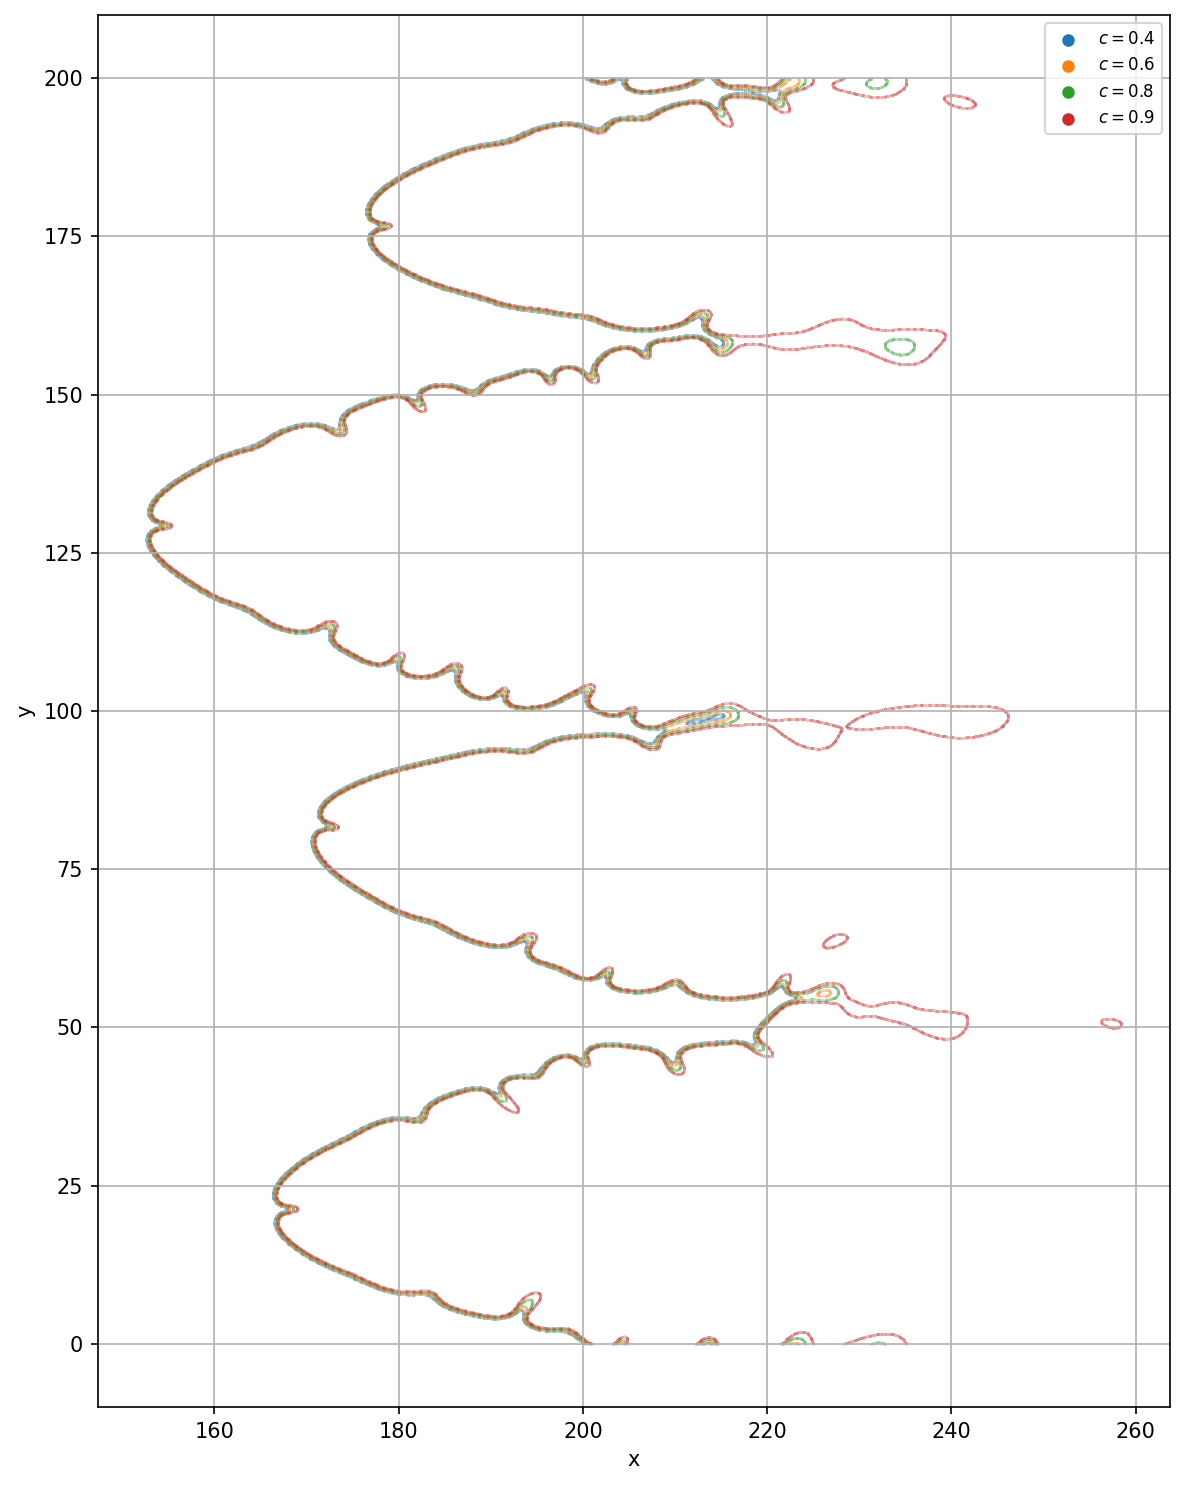

In [4]:
from flamekit.io_fields import make_case_with_base_dir
from flamekit.io_fronts import Case, folder, front_path
SCALARS = list(CFG["SCALARS"])


# ============================================================
# Case (new I/O)
# ============================================================



def _case_paths(case: Case, data_base_dir: Path, isocontour_base_dir: Path, iso: float):
    data_case = make_case_with_base_dir(case, data_base_dir)
    out_case = make_case_with_base_dir(case, isocontour_base_dir)
    folder_name = folder(data_case)
    save_dir = folder(out_case)
    out_path = front_path(out_case, float(iso))
    return folder_name, save_dir, out_path

comm = MPI.COMM_WORLD
rank = comm.rank

if MULTI_TIME_STEP:
    for TIME_STEP in range(TIME_STEP_START, TIME_STEP_END+1):
        # Minimal Case (as per your template)
        case = Case(
            base_dir=ISOCONTOUR_BASE_DIR,  # not used for extraction, but part of the unified convention
            phi=PHI,
            lat_size=LAT_SIZE,
            time_step=TIME_STEP,
            post=POST,
        )
        # derive paths using unified Case logic
        folder_name, save_dir, _ = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, PROGRESS_LEVELS[0])

        # Create output directory on rank 0
        if rank == 0:
            save_dir.mkdir(parents=True, exist_ok=True)

        # Create dataset
        ds = SEMDataset(
            file_name=FILE_NAME,
            folder_name=folder_name,          # <- can be Path now
            time_step=case.time_step,
            comm=comm,
            scalar_names=SCALARS,
        )


        # Create dataframe (as in your original script)
        df = ds.create_dataframe(
            compute_vel_jacobian=COMP_VEL_JACOBIAN,
            compute_vel_hessian=COMP_VEL_HESSIAN,
            compute_reaction_rates=COMP_REACTION_RATES,
            compute_T_grad=COMP_T_GRAD,
            compute_curv_grad=COMP_CURV_GRAD,
            cantera_inputs=CANTERA_INPUTS,
            compute_progress_var=True,
            phi=PHI,
        )

        # Plot on rank 0 only
        if rank == 0:
            fig, ax = plt.subplots(figsize=(8, 10), dpi=150)

        # Extract + save + plot (rank 0 handles IO/plotting)
        for iso in PROGRESS_LEVELS:
            front = ds.extract_flame_front(c_level=iso, scalar_name="progress_var")

            if rank == 0:
                _, save_dir, out_path = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, float(iso))
                front.to_csv(out_path, index=False)

                ax.scatter(
                    front["x"],
                    front["y"],
                    s=0.01,
                    alpha=1.0,
                    label=fr"$c={iso}$",
                )

        if rank == 0:
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.legend(markerscale=2, fontsize=8)
            ax.grid(True)
            plt.tight_layout()
            plt.show()
else:
# Minimal Case 
    case = Case(
        base_dir=ISOCONTOUR_BASE_DIR,  # not used for extraction, but part of the unified convention
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=TIME_STEP,
        post=POST,
    )
    # derive paths using unified Case logic
    folder_name, save_dir, _ = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, PROGRESS_LEVELS[0])

    # Create output directory on rank 0
    if rank == 0:
        save_dir.mkdir(parents=True, exist_ok=True)

    # Create dataset
    ds = SEMDataset(
        file_name=FILE_NAME,
        folder_name=folder_name,          # <- can be Path now
        time_step=case.time_step,
        comm=comm,
        scalar_names=SCALARS,
    )


    # Create dataframe 
    df = ds.create_dataframe(
        compute_vel_jacobian=COMP_VEL_JACOBIAN,
        compute_vel_hessian=COMP_VEL_HESSIAN,
        compute_reaction_rates=COMP_REACTION_RATES,
        compute_T_grad=COMP_T_GRAD,
        compute_curv_grad=COMP_CURV_GRAD,
        compute_local_vel_jacobian=COMP_LOCAL_VEL_JACOBIAN,
        cantera_inputs=CANTERA_INPUTS,
        compute_progress_var=True,
        phi=PHI,
    )

    # Plot on rank 0 only
    if rank == 0:
        fig, ax = plt.subplots(figsize=(8, 10), dpi=150)

    # Extract + save + plot (rank 0 handles IO/plotting)
    for iso in PROGRESS_LEVELS:
        front = ds.extract_flame_front(c_level=iso, scalar_name="progress_var")

        if rank == 0:
            _, save_dir, out_path = _case_paths(case, DATA_BASE_DIR, ISOCONTOUR_BASE_DIR, float(iso))
            front.to_csv(out_path, index=False)

            ax.scatter(
                front["x"],
                front["y"],
                s=0.01,
                alpha=1.0,
                label=fr"$c={iso}$",
            )

    if rank == 0:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend(markerscale=50, fontsize=8)
        ax.grid(True)
        plt.tight_layout()
        plt.show()
